# How to Access and Analyze GPM Data from the S3 Giovanni Cache Zarr Store

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Warning:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

<p></p>

<div style="background:#eeeeee; border:1px solid #cccccc;padding:5px 10px;color:black;"><big><b>Note:  GPM_IMERGHH is not intended for interannual analysis and here is used only for demonstration of working with data on a fine spatio-temporal scales.</b></big></div>

### Overview

This notebook demonstrates how to access the Giovanni Cache Zarr Store [S3 bucket](https://disc.gsfc.nasa.gov/information/faqs?keywords=%22earthdata%20cloud%22&title=What%20is%20S3%20access%3F) inside the [AWS us-west-2](https://disc.gsfc.nasa.gov/information/documents?title=Migrating%20to%20the%20Cloud) region for performing analysis. It accesses the [GPM IMERG Final Precipitation L3 Half Hourly 0.1 degree x 0.1 degree V06 precipitationCal](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_06/summary?keywords=GPM_3IMERGHH_06) variable Zarr Store, then subsets it over the Galapagos Islands (using the following bounding box: `[-91.6963, -1.4307, -89.212, 0.6514]`) over the 2014-2017 temporal range. Finally, it compares and plots monthly average precipitation between 2014-2017.

<img src="https://raw.githubusercontent.com/nasa/gesdisc-tutorials/main/images/Galapagos_Analysis_Area.png" alt="Galapagos Analysis Area" width="425">

Figure 1: The analysis area selected for this notebook (-91.6963, -1.4307, -89.212, 0.6514)

<img src="https://raw.githubusercontent.com/nasa/gesdisc-tutorials/main/images/Galapagos_Penguins.png" alt="Galapagos Penguins" width="425">

Figure 2: A pair of Galapagos Penguins

### Prerequisites

This notebook was written using Python 3.9, and requires these libraries and files: 
- netrc file with valid Earthdata Login credentials.
  - [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- Xarray
- requests
- S3FS
- Boto3
- NumPy
- Matplotlib
- Seaborn
- Pandas
- python-cmr
- re



### Import Libraries

In [1]:
import s3fs
import boto3
from IPython.display import display, Markdown
import requests
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from cmr import VariableQuery
import re

sns.set(style="ticks")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', message='.*Converting non-nanosecond precision datetime values to nanosecond precision.*')


### Check AWS Region before running notebook

A common error when executing this notebook occurs when the notebook is run outside of the us-west-2 AWS region. Here, we check the region using the Boto3 Python library, and throw a ValueError if you are outside the region.

This cell is not necessary to access the S3 buckets for users inside the us-west-2 region, and can be commented out or deleted at the users' discretion.

In [2]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

### us-west-2 Region Check: &#x2705;

### Read in Zarr store with temporary credentials and xarray
Specify the collection, version and variable you want to work with. 

In [3]:
short_name = "GPM_3IMERGHH"
version = "06"
variable = "precipitationCal"
provider = "GES_DISC"

In [4]:
def retrieve_credentials():
    """Makes the Oauth calls to authenticate with EDS and return a set of s3 same-region, read-only credentials."""
    response = requests.get("https://api.giovanni.earthdata.nasa.gov/s3credentials")
    response.raise_for_status()
    return response.json()

In [5]:
def query_all_zarr_stores(provider = None):
    api = VariableQuery()
    if provider: 
        all_vars = api.provider(provider).get_all()
    else:
        all_vars = api.get_all()

    zarrs = []
    for variable_entry in all_vars:
        try:
            if variable_entry['instance_information']['format'] == 'zarr':
                zarrs.append(variable_entry)
        except KeyError:
            continue
    return zarrs
    
def find_single_zarr_store(short_name, version, provider = None, variable = None):
    zarr_stores = query_all_zarr_stores(provider = provider)
    zarrs = []
    if variable:
        pattern = short_name + '.*' + version + '.*' + variable + '.*'
    else:         
        pattern = short_name + '.*' + version + '.*'

    for store in zarr_stores:
        try:
            if re.match(pattern, store["native_id"]):
                zarrs.append(store)
        except KeyError:
            continue
    return zarrs

In [6]:
def get_zarr_store(credentials, cmr_variable_metadata):
    s3 = s3fs.S3FileSystem(
        key=credentials["AccessKeyId"],
        secret=credentials["SecretAccessKey"],
        token=credentials["SessionToken"],
    )
    
    store = s3fs.S3Map(
        root=cmr_variable_metadata['instance_information']['url'], s3=s3, check=False
    )
    return store

In [7]:
zarr_metadata = find_single_zarr_store(short_name, version, provider, variable)
zarr_metadata

[{'long_name': 'Grid/precipitationCal',
  'definition': 'Grid/precipitationCal',
  'name': '/Grid/precipitationCal',
  'concept_id': 'V3019568737-GES_DISC',
  'associations': {'collections': ['C1598621093-GES_DISC']},
  'revision_id': 1,
  'provider_id': 'GES_DISC',
  'native_id': 'GPM_3IMERGHH_06_/Grid/precipitationCal',
  'instance_information': {'url': 's3://prod-giovanni-cache/zarr/GPM_3IMERGHH_06_precipitationCal',
   'format': 'zarr',
   'chunking_information': '(36, 72, 200)',
   'direct_distribution_information': {'region': 'us-west-2',
    's_3_credentials_api_endpoint': 'https://api.giovanni.earthdata.nasa.gov/s3credentials',
    's_3_credentials_api_documentation_url': 'https://api.giovanni.earthdata.nasa.gov/s3credentials'}},
  'association_details': {'collections': [{'concept_id': 'C1598621093-GES_DISC'}]}}]

Only one record returned since looking for a specific variable zarr store. Use the ```retrieve_credentials``` and ```get_zarr_store``` functions to obtain the data from AWS. 

In [8]:
credentials = retrieve_credentials()
store = get_zarr_store(credentials,zarr_metadata[0])

### Open Zarr Store using Xarray

In [9]:
%%time
data = xr.open_zarr(store=store, consolidated=False)

CPU times: user 14.1 s, sys: 395 ms, total: 14.5 s
Wall time: 19.8 s


In [10]:
data

<xarray.Dataset> Size: 10TB
Dimensions:           (latitude: 1800, bounds: 2, longitude: 3600, time: 374200)
Coordinates:
  * latitude          (latitude) float32 7kB -89.95 -89.85 ... 89.85 89.95
  * longitude         (longitude) float32 14kB -179.9 -179.9 ... 179.9 179.9
  * time              (time) datetime64[ns] 3MB 2000-06-01 ... 2000-05-31T23:...
Dimensions without coordinates: bounds
Data variables:
    latitude_bounds   (latitude, bounds) float32 14kB dask.array<chunksize=(36, 2), meta=np.ndarray>
    longitude_bounds  (longitude, bounds) float32 29kB dask.array<chunksize=(72, 2), meta=np.ndarray>
    time_bounds       (time, bounds) datetime64[s] 6MB dask.array<chunksize=(200, 2), meta=np.ndarray>
    variable          (latitude, longitude, time) float32 10TB dask.array<chunksize=(36, 72, 200), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.10
    DOI:                 10.5067/GPM/IMERG/3B-HH/06
    product_long_name:   GPM IMERG Final Precipitation L3 Half Hourly 0.1 deg...
    product_short_name:  GPM_3IMERGHH
    product_version:     06

Mask and drop where there are fill values (numpy.datetime64('2000-05-31T23:00:00'))

In [11]:
data_masked_dropped = data.where(data["time"] != data["time"]._FillValue, drop=True)
data_masked_dropped = data.sortby('time')

### Define a time range and a bounding box covering the Galapagos Islands

In [12]:
var_name = "variable" 
start_time = "2014-01-01T00:00:00" 
end_time = "2017-12-31T23:30:00" 
time_slice = slice(start_time, end_time) 
start_year = int(start_time.split("-")[0])
end_year = int(end_time.split("-")[0]) + 1

bbox = [-91.6963, -1.4307, -89.212, 0.6514] 
lon_slice = slice(bbox[0], bbox[2]) 
lat_slice = slice(bbox[1], bbox[3])

In [13]:
data_subset = data_masked_dropped.sel( 
    time=time_slice, 
    latitude=lat_slice, 
    longitude=lon_slice, 
)

In [14]:
data_subset

<xarray.Dataset> Size: 149MB
Dimensions:           (latitude: 21, bounds: 2, longitude: 25, time: 70128)
Coordinates:
  * latitude          (latitude) float32 84B -1.35 -1.25 -1.15 ... 0.55 0.65
  * longitude         (longitude) float32 100B -91.65 -91.55 ... -89.35 -89.25
  * time              (time) datetime64[ns] 561kB 2014-01-01 ... 2017-12-31T2...
Dimensions without coordinates: bounds
Data variables:
    latitude_bounds   (latitude, bounds) float32 168B dask.array<chunksize=(14, 2), meta=np.ndarray>
    longitude_bounds  (longitude, bounds) float32 200B dask.array<chunksize=(25, 2), meta=np.ndarray>
    time_bounds       (time, bounds) datetime64[s] 1MB dask.array<chunksize=(24, 2), meta=np.ndarray>
    variable          (latitude, longitude, time) float32 147MB dask.array<chunksize=(14, 25, 24), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.10
    DOI:                 10.5067/GPM/IMERG/3B-HH/06
    product_long_name:   GPM IMERG Final Precipitation L3 Half Hourly 0.1 deg...
    product_short_name:  GPM_3IMERGHH
    product_version:     06

### Calculate the monthly averages and the weighted area-averaged time series

In [15]:
def average_time_series(data, var_name):
    """Calculate the monthly averages and weighted area-averaged time series."""
    # Calculate monthly average
    data_monthly_avg = data.resample(time="1M").mean()
    
    # Calculate the weights
    lat_weights = np.cos(np.pi*data_monthly_avg.latitude/180.0)

    # Project the weights onto an array that is the same shape as the subset
    lat_weights = np.logical_not(np.isnan(data_monthly_avg[var_name]))*lat_weights

    # Calculate the average
    data_avg = (lat_weights * data_monthly_avg[var_name]).sum(dim=("latitude","longitude"))/lat_weights.sum(dim=("latitude","longitude"))
    
    return data_avg

In [16]:
data_avg = average_time_series(data_subset, var_name)

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [17]:
data_avg

<xarray.DataArray (time: 48)> Size: 192B
dask.array<truediv, shape=(48,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 384B 2014-01-31 2014-02-28 ... 2017-12-31

### Plot the time series

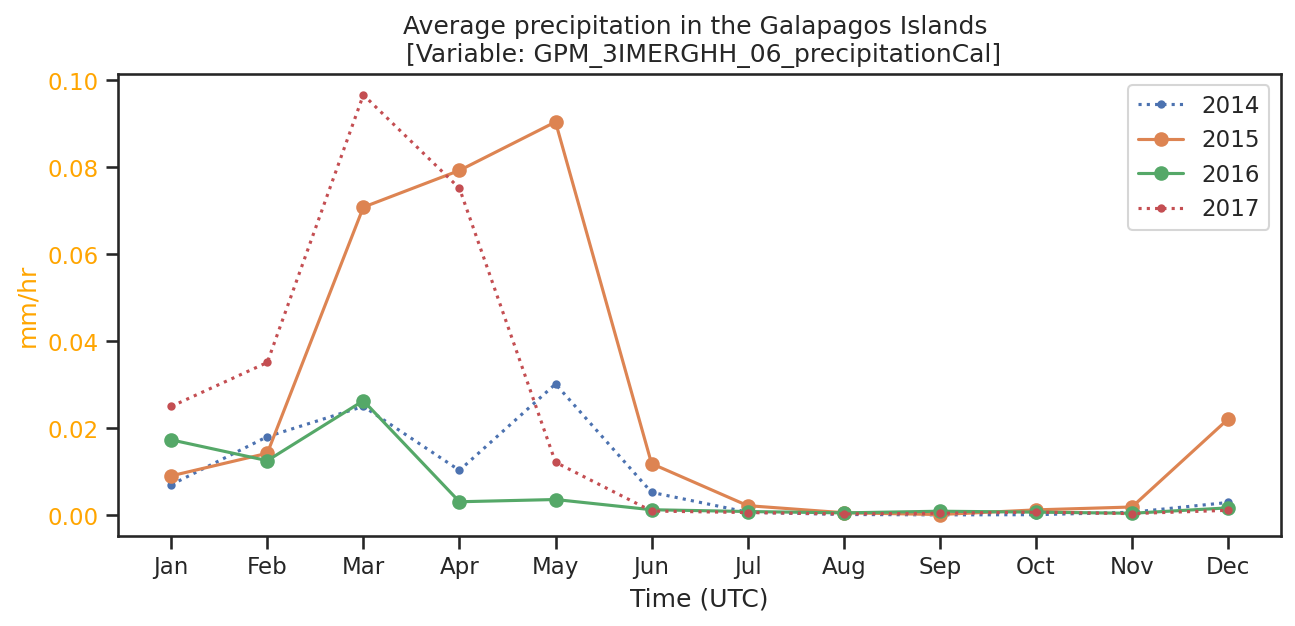

CPU times: user 41.9 s, sys: 3 s, total: 44.9 s
Wall time: 53.1 s


In [18]:
%%time
fig, ax1 = plt.subplots(figsize=(10,4), dpi=150)

month_ticks = range(1, 13)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
for year in range(start_year, end_year):
    year_data = data_avg.loc[f"{year}-01-01":f"{year}-12-31"]
    if year == 2015 or year == 2016:
        ax1.plot(year_data.time.dt.month, year_data.values, label=year, marker="o")
    else:
        ax1.plot(year_data.time.dt.month, year_data.values, label=year, linestyle=":", marker=".")
        
ax1.set_ylabel("mm/hr", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")

handles, labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles,labels)

plt.title("Average precipitation in the Galapagos Islands \n [Variable: GPM_3IMERGHH_06_precipitationCal]")
plt.xlabel("Time (UTC)")
plt.xticks(month_ticks, month_labels)
plt.show()

# Acknowledgments

Openscapes for providing Jupyter Hub access, Jim Acker for coming up with the scenario, Christine Smit for the area averaging function, Faith Giguere for the method to get temporary AWS credentials, and the Cloud Giovanni team for contributing to this epic.